In [53]:
# 1. Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
# 2. Load dataset
df = pd.read_csv("hour.csv")

In [57]:
# 3. Preprocessing
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

In [59]:
# Define features and target
X = df.drop('cnt', axis=1)
y = df['cnt']

In [61]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [63]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [65]:
# 5. Model with GridSearchCV
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1]
}

grid = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [66]:
# Best model evaluation
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Initial Model Performance:")
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Initial Model Performance:
R2 Score: 0.9472949504852295
RMSE: 40.85251016554001


In [67]:
# 6. Feature Selection with RFE
rfe = RFE(estimator=best_model, n_features_to_select=5)
rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print("\nSelected Features by RFE:", list(selected_features))



Selected Features by RFE: ['season', 'yr', 'hr', 'workingday', 'temp']


In [68]:
# Retrain with selected features
X_train_sel = X_train[:, rfe.support_]
X_test_sel = X_test[:, rfe.support_]

best_model.fit(X_train_sel, y_train)
y_pred_sel = best_model.predict(X_test_sel)

print("\nRetrained Model Performance with Selected Features:")
print("R2 Score:", r2_score(y_test, y_pred_sel))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_sel)))


Retrained Model Performance with Selected Features:
R2 Score: 0.8955662250518799
RMSE: 57.505982233285124


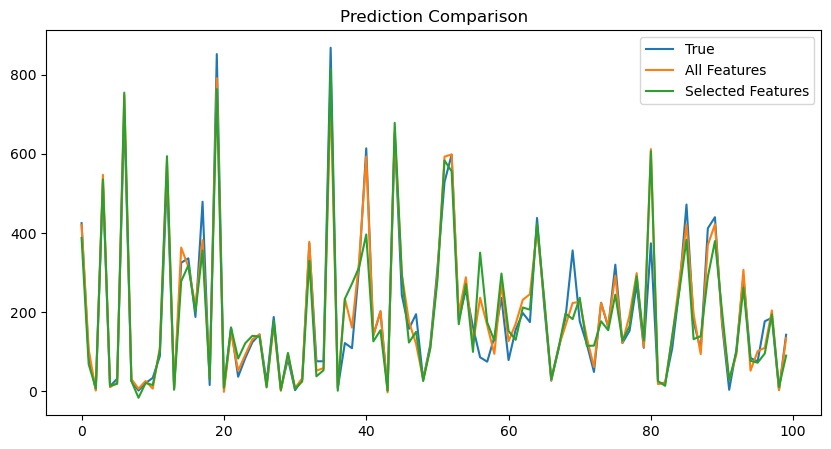

In [73]:
# 7. Comparison Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='True')
plt.plot(y_pred[:100], label='All Features')
plt.plot(y_pred_sel[:100], label='Selected Features')
plt.legend()
plt.title("Prediction Comparison")
plt.show()


In [75]:
# 8. Save the model and scaler
import joblib

joblib.dump(best_model, 'xgb_rfe_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(list(selected_features), 'selected_features.pkl')

print("\n Model, scaler, and selected features saved successfully.")

# 9. Deployment: Real-time user input
def predict_from_user_input():
    print("\nEnter values for the following features:")
    try:
        season = int(input("Season (1:spring, 2:summer, 3:fall, 4:winter): "))
        yr = int(input("Year (0 for 2011, 1 for 2012): "))
        hr = int(input("Hour of day (0 to 23): "))
        workingday = int(input("Working Day? (1 for yes, 0 for no): "))
        temp = float(input("Normalized Temperature (e.g., 0.5 for ~20°C): "))
    except ValueError:
        print("Invalid input. Please enter numeric values.")
        return

    # Create default row and replace selected features
    default_input = pd.DataFrame([X.mean()], columns=X.columns)
    default_input['season'] = season
    default_input['yr'] = yr
    default_input['hr'] = hr
    default_input['workingday'] = workingday
    default_input['temp'] = temp

    # Scale the input
    scaler = joblib.load('scaler.pkl')
    selected_features = joblib.load('selected_features.pkl')
    model = joblib.load('xgb_rfe_model.pkl')

    input_scaled = scaler.transform(default_input)
    input_selected = input_scaled[:, [X.columns.get_loc(f) for f in selected_features]]

    # Predict
    prediction = model.predict(input_selected)
    print(f"\n Predicted Bike Count (cnt): {int(prediction[0])}")





 Model, scaler, and selected features saved successfully.


In [77]:
predict_from_user_input()


Enter values for the following features:


Season (1:spring, 2:summer, 3:fall, 4:winter):  1
Year (0 for 2011, 1 for 2012):  0
Hour of day (0 to 23):  2
Working Day? (1 for yes, 0 for no):  0
Normalized Temperature (e.g., 0.5 for ~20°C):  0.22



 Predicted Bike Count (cnt): 24
